# Ladybug classification

In this notebook, we will try to classify ladybugs using a simple machine learning model. The dataset contains extracted features from images of ladybugs, such as color of the shell, number and brightness of the spots.

In [14]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

We will label encode our categorical features and use a Random Forest Classifier to classify the ladybug species based on the extracted features.
We will also use GridSearchCV to find the best hyperparameters for our model.

In [15]:
# Load dataset
df = pd.read_csv("training_labels_completed.csv")

# Drop Image_id and separate features/target
X = df.drop(columns=["Image_id", "Label"])
y = df["Label"]

# Define categorical and numerical columns
categorical_cols = ["shell_brightness", "spots_brightness"]
numerical_cols = ["spots_number"]

# Preprocessing: one-hot encode categorical, pass through numerical
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), categorical_cols)
], remainder="passthrough")

# Pipeline with Random Forest
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Grid of hyperparameters for Random Forest
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__criterion": ["gini", "entropy"]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)

# Output best model parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best Cross-Validated Accuracy: 0.925


Now that our model is trained with cross-validation, we can visualize one of the decision trees from the Random Forest model.

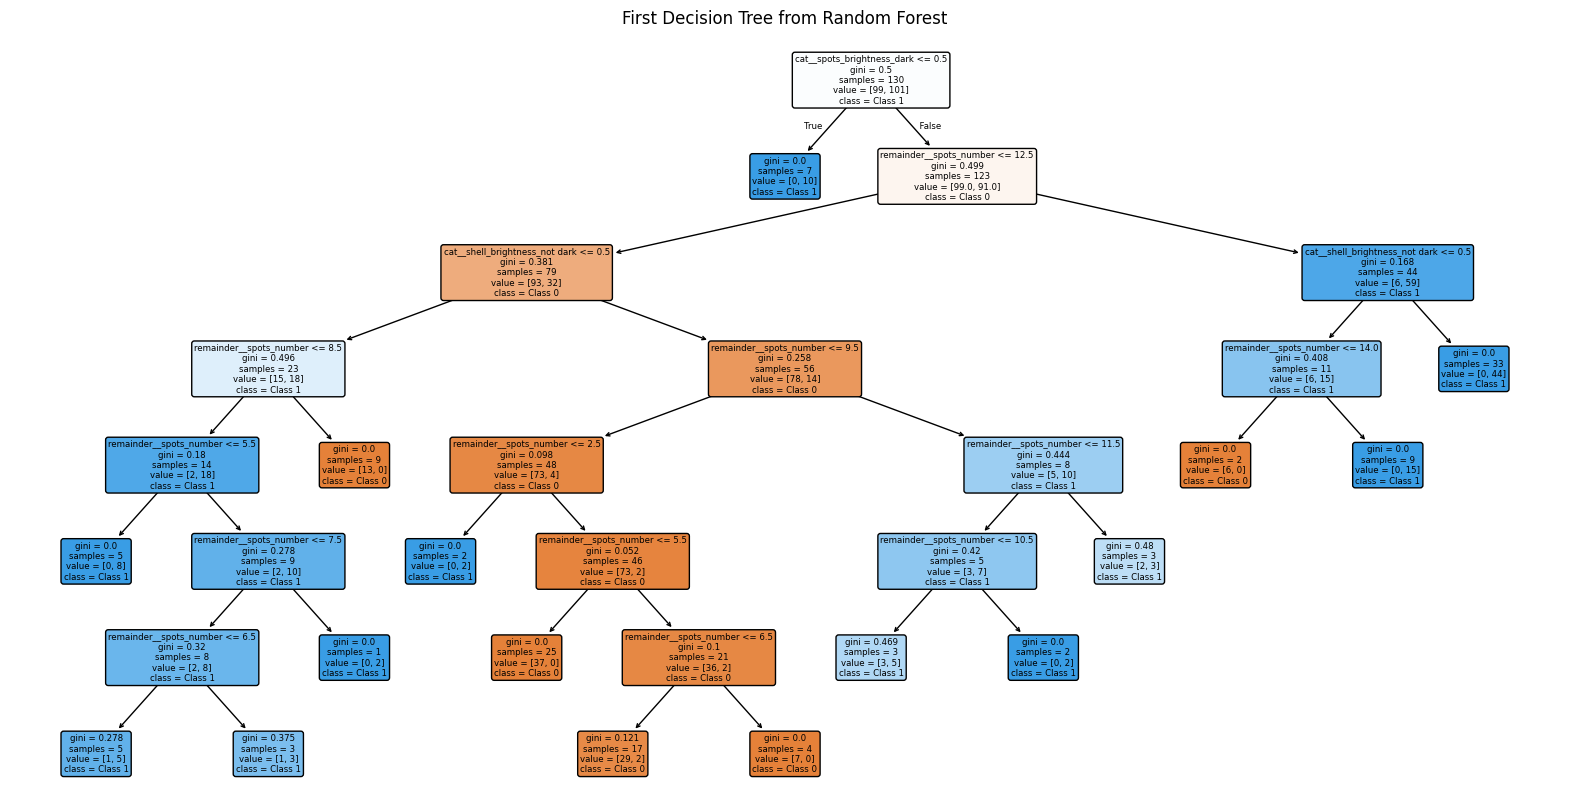

In [16]:
best_rf = grid_search.best_estimator_.named_steps["classifier"]

estimator = best_rf.estimators_[0]

feature_names = grid_search.best_estimator_.named_steps["preprocessing"].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=feature_names, class_names=["Class 0", "Class 1"], filled=True, rounded=True)
plt.title("First Decision Tree from Random Forest")
plt.show()


We can now use the optimal hyperparameters to train a Random Forest Classifier on the training dataset and test it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = grid_search.best_params_

# Remove the "classifier__" prefix
rf_best = RandomForestClassifier(
    n_estimators=best_params["classifier__n_estimators"],
    max_depth=best_params["classifier__max_depth"],
    min_samples_split=best_params["classifier__min_samples_split"],
    min_samples_leaf=best_params["classifier__min_samples_leaf"],
    criterion=best_params["classifier__criterion"],
    random_state=42
)

final_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", rf_best)
])

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [18]:
test_df = pd.read_csv("test_labels_completed.csv")

X_test_real = test_df.drop(columns=["Image_id", "Label"])
y_test_real = test_df["Label"]

y_pred_test = final_pipeline.predict(X_test_real)

print("Test Dataset Accuracy:", accuracy_score(y_test_real, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_real, y_pred_test))

Test Dataset Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

